# Calculate the time-mean SST from Copernicus Marine Data Service : OSTIA

In [1]:
#install the copernicusmarine package (only need to do this the very first time!)

#see https://help.marine.copernicus.eu/en/articles/7970514-copernicus-marine-toolbox-installation#h_31a829a1b8

!conda install -y -n senemo-env -c conda-forge copernicusmarine



Retrieving notices: ...working... done
Channels:
 - conda-forge
 - bodc
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.7.1
    latest version: 24.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/users/cwilso01/.conda/envs/senemo-env

  added / updated specs:
    - copernicusmarine


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asciitree-0.3.3            |             py_2           6 KB  conda-forge
    boto3-1.35.35              |     pyhd8ed1ab_0          81 KB  conda-forge
    botocore-1.35.35           | pyge38_1234567_0         7.0 MB  conda-forge
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    cachier-3.0.1              |     pyhd8ed1ab_0          24 KB  conda-forge
    cer

### Import packages, including the copernicusmarine package for reading OSTIA

In [2]:
import xarray as xr
from dask.diagnostics import ProgressBar
from dask.distributed import Client

import copernicusmarine

/home/users/cwilso01/.conda/envs/senemo-env/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


### Load data

In [ ]:
#lazy-load OSTIA SST data
#see https://help.marine.copernicus.eu/en/articles/8287609-copernicus-marine-toolbox-api-open-a-dataset-or-read-a-dataframe-remotely


##quick look
#copernicusmarine.open_dataset(dataset_id='METOFFICE-GLO-SST-L4-REP-OBS-SST',end_datetime="2019-12-31")

In [2]:
copernicusmarine.login  #This should allow the user to login using their credentials the first time, saving them in a file to speed up future logins, but it would not work.

<function copernicusmarine.python_interface.login.login(username: Optional[str] = None, password: Optional[str] = None, configuration_file_directory: pathlib.Path = PosixPath('/home/users/cwilso01/.copernicusmarine'), overwrite_configuration_file: bool = False, skip_if_user_logged_in: bool = False) -> bool>

In [31]:
ds=copernicusmarine.open_dataset(dataset_id='METOFFICE-GLO-SST-L4-REP-OBS-SST',end_datetime="2019-12-31")

##subset in ~10 year chunks, to prevent kernel crashing later
#ds = ds.sel(time=slice('1982-01-01', '1989-12-31'))
#ds = ds.sel(time=slice('1990-01-01', '1999-12-31'))
#ds = ds.sel(time=slice('2000-01-01', '2009-12-31'))
ds = ds.sel(time=slice('2010-01-01', '2019-12-31'))

INFO - 2024-10-14T11:43:22Z - Dataset version was not specified, the latest one was selected: "202003"
INFO - 2024-10-14T11:43:22Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-10-14T11:43:24Z - Service was not specified, the default one was selected: "arco-geo-series"


username:

  cwi@noc.ac.uk


password:

  ········


In [32]:
ds

<xarray.Dataset> Size: 3TB
Dimensions:           (time: 3652, latitude: 3600, longitude: 7200)
Coordinates:
  * latitude          (latitude) float32 14kB -89.97 -89.93 ... 89.93 89.97
  * longitude         (longitude) float32 29kB -180.0 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 29kB 2010-01-01 ... 2019-12-31
Data variables:
    analysed_sst      (time, latitude, longitude) float64 757GB ...
    analysis_error    (time, latitude, longitude) float64 757GB ...
    mask              (time, latitude, longitude) float32 379GB ...
    sea_ice_fraction  (time, latitude, longitude) float64 757GB ...
Attributes: (12/47)
    Conventions:                CF-1.4, ACDD-1.3
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    WARNING Some applications are unable to prope...
    creator_email:              servicedesk.cmems@mercator-ocean.eu
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    time_coverage_end:          19811002T000000Z
    time_coverage_start:        19811001T000000Z
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    uuid:                       a2df4a18-6f19-4772-9532-39307a0e2794
    westernmost_longitude:      -180.0

### Coarsen the data in lat and lon (by taking the NxN grid-mean, in a coarsegraining operation) and subsample every 30th point in time (i.e. every 30d)

In [33]:
sst=ds.analysed_sst

coarsen_factors = {'latitude': 5, 'longitude': 5}
# Subsample every 30th time value
subsampled_sst = sst.isel(time=slice(None, None, 30))

In [34]:
subsampled_sst

<xarray.DataArray 'analysed_sst' (time: 122, latitude: 3600, longitude: 7200)> Size: 25GB
[3162240000 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) datetime64[ns] 976B 2010-01-01 2010-01-31 ... 2019-12-10
Attributes:
    comment:         OSTIA foundation SST
    long_name:      analysed sea surface temperature
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    source:         AMSR2-REMSS-L2P-v2.0, AMSRE-REMSS-L2P-v2.0, TMI-REMSS-L2P...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      4500
    valid_min:      -300

### Chunk the data into large chunks, so that the later operation will result in chunks ~10 MB, rather than too small (i.e. which would have comms overhead).  Rechunking later seems to take ages.

In [35]:
#subsstchunked=subsampled_sst.chunk({'time':-1,'longitude':180, 'latitude':90})
subsstchunked=subsampled_sst.chunk({'time':-1,'longitude':1800, 'latitude':180})

In [36]:
subsstchunked

<xarray.DataArray 'analysed_sst' (time: 122, latitude: 3600, longitude: 7200)> Size: 25GB
dask.array<xarray-<this-array>, shape=(122, 3600, 7200), dtype=float64, chunksize=(122, 180, 1800), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) datetime64[ns] 976B 2010-01-01 2010-01-31 ... 2019-12-10
Attributes:
    comment:         OSTIA foundation SST
    long_name:      analysed sea surface temperature
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    source:         AMSR2-REMSS-L2P-v2.0, AMSRE-REMSS-L2P-v2.0, TMI-REMSS-L2P...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      4500
    valid_min:      -300

### Do the coarsegraining

In [37]:
sst_subsampled_coarsegrained=subsstchunked.coarsen(coarsen_factors, boundary='trim').mean()

/home/users/cwilso01/.conda/envs/senemo-env/lib/python3.9/site-packages/xarray/core/rolling.py:1122: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  reduced = self.obj.variable.coarsen(


In [38]:
sst_subsampled_coarsegrained

<xarray.DataArray 'analysed_sst' (time: 122, latitude: 720, longitude: 1440)> Size: 1GB
dask.array<mean_agg-aggregate, shape=(122, 720, 1440), dtype=float64, chunksize=(122, 36, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB -89.87 -89.62 -89.37 ... 89.38 89.63 89.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time       (time) datetime64[ns] 976B 2010-01-01 2010-01-31 ... 2019-12-10
Attributes:
    comment:         OSTIA foundation SST
    long_name:      analysed sea surface temperature
    reference:      C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. F...
    source:         AMSR2-REMSS-L2P-v2.0, AMSRE-REMSS-L2P-v2.0, TMI-REMSS-L2P...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      4500
    valid_min:      -300

### Calculate the time-mean

In [40]:
%%time
# Efficient time-mean calculation (chunking first if necessary)
#sst_time_mean_cg = sst_subsampled_coarsegrained.chunk({'time': -1, 'longitude': 720, 'latitude': 1440}).mean(dim='time')
sst_time_mean_cg = sst_subsampled_coarsegrained.mean(dim='time')

sst_cg_time_mean=sst_time_mean_cg.compute()

CPU times: user 4min 54s, sys: 55.2 s, total: 5min 50s
Wall time: 10min 58s


### Save the result of the calculation

In [41]:
#sst_cg_time_mean.to_netcdf('~/projects/senemo/data/interim/OSTIA/sst_cg_fac5lon_fac5lat_fac30time_19820101_19891231.nc')
#sst_cg_time_mean.to_netcdf('~/projects/senemo/data/interim/OSTIA/sst_cg_fac5lon_fac5lat_fac30time_19900101_19991231.nc')
#sst_cg_time_mean.to_netcdf('~/projects/senemo/data/interim/OSTIA/sst_cg_fac5lon_fac5lat_fac30time_20000101_20091231.nc')
sst_cg_time_mean.to_netcdf('~/projects/senemo/data/interim/OSTIA/sst_cg_fac5lon_fac5lat_fac30time_20100101_20191231.nc')

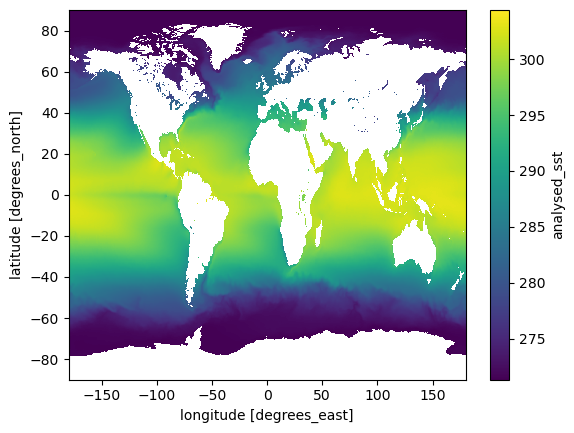

In [42]:
sst_cg_time_mean.plot()